# Self-play


For a lot of realistic multi-agent environments, the problem is too complex to solve the optimal policy exactly (within a reasonable amount of time).\
This is due to the explosion of complexity associated with having multiple agents. \
In order to solve exactly, one has to consider not just all possible actions of one agent, but all possible combined actions of all the agents in the environment together.\
\
So, in practice the optimal policy is often approximated. \
A common technique is to learn a single agent policy that is trained by playing with/against user-defined agent models.\
\
**Self-play** is broadly defined as a multi-agent learning paradigm where a single agent is trained by player with/against (a version of) itself.\
This notebook will train a basic self-play agent to learn to play the lever coordination game.

Let's start with importing some modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from env.lever_game import LeverGame
from util.logger import Logger
from util.render import Renderer
from agents.qlearning import QLearning
from agents.exploration import LinearDecay

defining some hyper-parameters which we will use later

In [2]:
total_episodes = 100     # number of episodes we're going to train for
population = 30          # number of agents we're going to train simultaneously

# e-greedy hyperparameters
epsilon_start = 1
epsilon_end = 0.01
decayed_by = total_episodes / 2

and defining a utility function that initializes a population of players to train

In [3]:
def init_population(num_actions, population_size):
    players = []
    for _ in range(population_size):
        p = QLearning(1, num_actions)
        players.append(p)
    return players

## Training
In the most basic version of self-play the agent plays with a direct clone of itself:

In [4]:
def self_play_action(player, state, episode, strategy):
    # our player
    a1 = player.select_action(state, epsilon=strategy.get_epsilon(episode))
    
    # the clone
    a2 = player.select_action(state, epsilon=strategy.get_epsilon(episode))
    
    return (a1, a2)

Let's train a population of self-play agents and see how well they perform

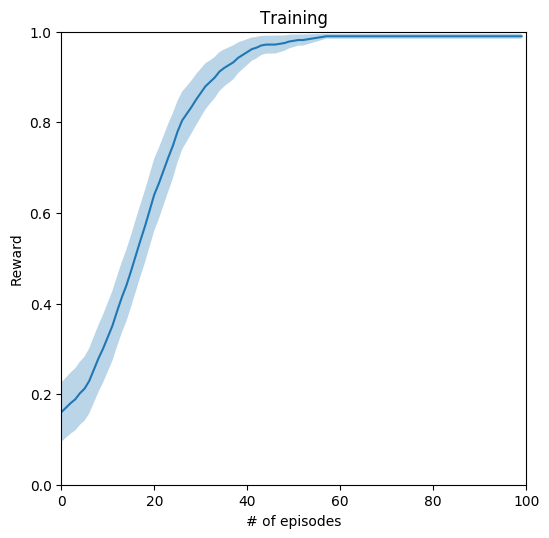

In [5]:
env = LeverGame()
log = Logger(population, total_episodes)

players = init_population(env.num_levers, population)
strategy = LinearDecay(epsilon_start, epsilon_end, decayed_by)

for episode in range(total_episodes):
    for p in range(population):
        player = players[p]

        state = 0     # arbitrarily defined initial state

        action = self_play_action(player, state, episode, strategy)

        observation, reward, done, info = env.step(action)

        # our environment only has a single state
        next_state = state

        player.update_q_values(state, action[0], next_state, reward, done)

        # log training process
        _, r, _, _ = env.step((player.get_optimal_action(state), player.get_optimal_action(state)))
        log.update_training_log(p, episode, r, action)  
        
log.show_results(smoothness=20)

The agents seem to be able to converge during training to the maximum reward of 1.

### Agent Visualisation
Let's visualize the Q values of our self-play agent during training to gain a better understanding of what it is learning:

In [6]:
render_interval = 0
file_name = 'regular_self_play'

env = LeverGame()
player = QLearning(1, env.num_levers)
renderer = Renderer(total_episodes, player)
strategy = LinearDecay(epsilon_start, epsilon_end, decayed_by)

# Loop
for episode in range(total_episodes):     
    state = 0     # arbitrarily defined initial state

    action = self_play_action(player, state, episode, strategy)

    observation, reward, done, info = env.step(action)

    # our environment only has a single state
    next_state = state

    player.update_q_values(state, action[0], next_state, reward, done)

    renderer.store_q_values(episode, player)

renderer.render_q_values(file_name, render_interval)

In [7]:
from IPython.display import Markdown as md

# Display the gif created above
md(f'![](gif/{file_name}.gif)')

![](gif/regular_self_play.gif)

As we can see from the gif above, our self-play agent settles on a policy where it simply selects the same lever all the time. \
This is a great strategy when playing with a clone of yourself, as it guarantees the reward associated with that lever every time.

## Testing (Zero-Shot Coordination)
The lever coordination game is not very complicated when you play it with yourself. \
A much more interesting scenario to play the game is that of *zero-shot coordination* 

In zero-shot coordination, agents are placed in a situation in which they have to cooperate with novel partners they have not encountered during training.\
In other words, in zero-shot coordination an agent must play with strangers. \
\
For the lever coordination game, we test our agent's zero-shot coordination performance through cross-play (playing with every other agent in the population except yourself). \
This is a zero-shot coordination setting because all the agents in the population are trained independently. 

In [8]:
def cross_play_testing(players):
    population_size = len(players)
    reward_matrix = np.zeros((population_size, population_size))
    
    state = 0
    
    for i1 in range(population_size):
        for i2 in range(i1):
            p1 = players[i1]
            p2 = players[i2]
            
            state = 0
            
            action = (p1.get_optimal_action(state), p2.get_optimal_action(state))
            _, r, _, _ = env.step(action)
            
            reward_matrix[i1,i2] = r
            
    # the reward matrix is symmetric
    reward_matrix = reward_matrix + np.transpose(reward_matrix)
    
    return reward_matrix

Let's see how the basic self-play agent performs in the cross-play (zero-shot coordination) scenario:

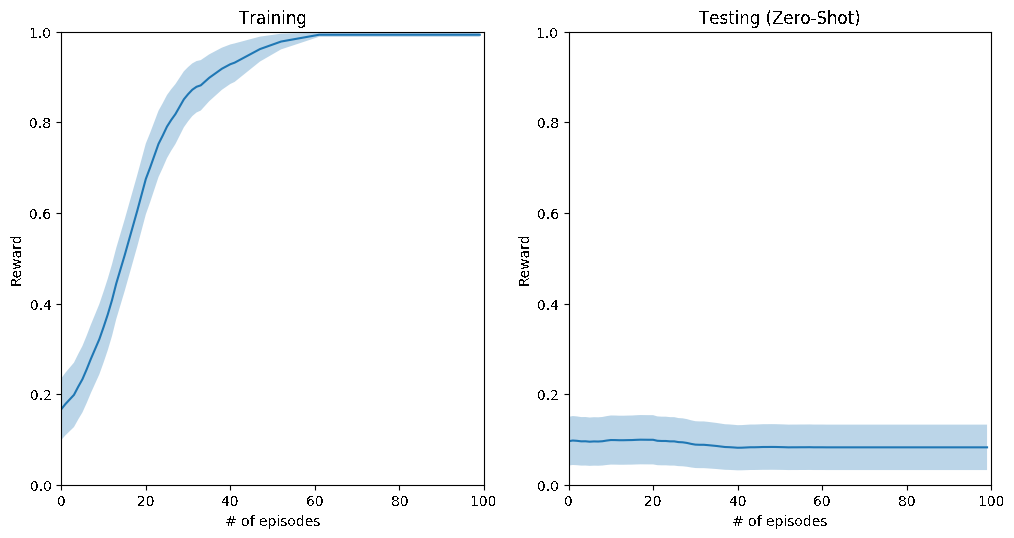

In [9]:
env = LeverGame()
log = Logger(population, total_episodes)

players = init_population(env.num_levers, population)
strategy = LinearDecay(epsilon_start, epsilon_end, decayed_by)

for episode in range(total_episodes):
    
    # Training
    for p in range(population):
        player = players[p]

        state = 0     # arbitrarily defined initial state

        action = self_play_action(player, state, episode, strategy)

        observation, reward, done, info = env.step(action)

        # our environment only has a single state
        next_state = state

        player.update_q_values(state, action[0], next_state, reward, done)

        # log training process
        _, r, _, _ = env.step((player.get_optimal_action(state), player.get_optimal_action(state)))
        log.update_training_log(p, episode, r, action)
            
    
    # Cross-play Testing
    rewards = cross_play_testing(players)
    
    log.update_testing_log(episode, rewards)
    
        
log.show_results(smoothness=20)

As we can see, the self-play agent has very poor performance in the zero-shot coordination setting. \
This is because settling on a policy that always selects the same lever is not really optimal, if you cannot agree with your partner *which* lever to select beforehand. 